<a href="https://colab.research.google.com/github/Geoffrey-Z/Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price/blob/master/BI_COLOR_Week_of_Pollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price

## Step 1: Verify that all requires libraries can be imported

In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Step 2: Load the data

In [7]:
from google.colab import files
uploaded = files.upload()
#dataset = np.loadtxt("https://github.com/Geoffrey-Z/Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras-for-CORN-SWEET-Terminal-Market-Price/blob/master/BI-COLOR%20PRICE%20weeks.csv")

Saving BI-COLOR PRICE weeks.csv to BI-COLOR PRICE weeks.csv


In [0]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('BI-COLOR PRICE weeks.csv', index_col=0)
# mark all NA values with 0
dataset['price'].fillna(0, inplace=True)

# Step 3: Preview first 5 rows and all columns

In [10]:
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('BI-COLOR PRICE weeks.csv')

               price      WHITE     YELLOW
date                                      
1/10/1998  11.520833  12.836538  11.740385
1/17/1998  14.375000  13.979167  13.211538
1/24/1998  13.725000  12.973958  11.096154
1/31/1998  13.833333  13.572917  10.883929
2/7/1998   15.805556  15.283333  14.468750


# Step 4: Visualize input data

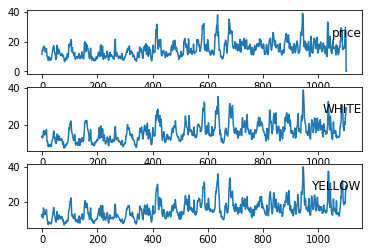

In [11]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('BI-COLOR PRICE weeks.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

# Step 5: LSTM Data Preparation

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('BI-COLOR PRICE weeks.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.294462   0.177804   0.143801  0.367412
2   0.367412   0.214058   0.188242  0.350799
3   0.350799   0.182164   0.124340  0.353568
4   0.353568   0.201168   0.117929  0.403976
5   0.403976   0.255437   0.226221  0.418530


# Step 6: Split the data into Training Set (first 70% rows) and Validation Set (remaining 30% rows)
### - The first 3 columns (0 to 2) are our features used as input to the model
### - The last column (3) is the output variable

In [13]:
# split into train and test sets
values = reframed.values
##n_train_hours = 365 * 24
train = values[:int(len(values)*0.7), :]
test = values[int(len(values)*0.7):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(770, 1, 3) (770,) (331, 1, 3) (331,)


# Step 7: Create a LSTM network model with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting price.
### The input shape will be 1 time step with 3 features.

In [14]:
# Design network
model = Sequential()
# Check LSTM
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 770 samples, validate on 331 samples
Epoch 1/1000
 - 1s - loss: 0.3383 - val_loss: 0.3896
Epoch 2/1000
 - 0s - loss: 0.2755 - val_loss: 0.3157
Epoch 3/1000
 - 0s - loss: 0.2078 - val_loss: 0.2345
Epoch 4/1000
 - 0s - loss: 0.1319 - val_loss: 0.1421
Epoch 5/1000
 - 0s - loss: 0.0635 - val_loss: 0.0779
Epoch 6/1000
 - 0s - loss: 0.0569 - val_loss: 0.0698
Epoch 7/1000
 - 0s - loss: 0.0598 - val_loss: 0.0720
Epoch 8/1000
 - 0s - loss: 0.0560 - val_loss: 0.0783
Epoch 9/1000
 - 0s - loss: 0.0534 - val_loss: 0.0774
Epoch 10/1000
 - 0s - loss: 0.0519 - val_loss: 0.0740
Epoch 11/1000
 - 0s - loss: 0.0513 - val_loss: 0.0732
Epoch 12/1000
 - 0s - loss: 0.0505 - val_loss: 0.0733
Epoch 13/1000
 - 0s - loss: 0.0495 - val_loss: 0.0729
Epoch 14/1000
 - 0s - loss: 0.0488 - val_loss: 0.0724
Epoch 15/1000
 - 0s - loss: 0.0482 - val_loss: 0.0720
Epoch 16/1000
 - 0s - loss: 0.047

KeyboardInterrupt: ignored

## Step 6: Check for proper neural connections by compiling the model
### We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [0]:
model.compile(loss='mae', optimizer='adam', metrics=['mse']) # mse = mean squared error

## Step 7: Do the Training (Fit the model)
At the end of the run both the training and test loss are plotted.

### The model will be fit for 50 training epochs with a batch size of 72.



In [0]:
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### The model will be fit for 1000 training epochs with a batch size of 72.

In [0]:
# Fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### The model will be fit for 1000 training epochs with a batch size of 1.

In [0]:
# Fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Step 8: The real test of the model we trained
**Evaluate the model on the Test data, calculate the Root Mean Squared Error (RMSE) **

In [0]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

## Calculate R^2 (coefficient of determination) regression score

In [0]:
import math
from keras.models import load_model
model.save('my_model.h5')
model = load_model('my_model.h5')
from sklearn.metrics import r2_score
#trainScore = math.sqrt(r2_score(test_y[0],  yhat[:,0]))
#print('Train Score: %.2f R2' % (trainScore))
testScore = math.sqrt(r2_score(inv_y, inv_yhat))
print('Test Score: %.2f R2' % (testScore))